# 프로젝트 : CAM & Grad-CAM 시각화
2024-07-05
### 데이터 : stanford_dogs
### 모델 : ResNet50

### 1. CAM
### 2. Grad-CAM
### 3. Bounding Box
- Grad-CAM
- IOU

## 0. 라이브러리

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# model,history save,load
import pickle
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

tf.config.list_physical_devices('GPU')

2.6.0
1.21.4
4.5.3
8.3.2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터
- Stanford_dogs
    - 위치정보 : 바운딩 박스를 포함
    - 데이터 저장, 로드 : data_dir=data_dir
- `ds_info.features`
    - image, label : 이미지, 클래스 인덱스
    - bbox(BBoxFeature) : 바운딩 박스
    - **minmax** : 바운딩박스를 이루는 좌표의 최솟값, 최대값을 통해 표기
        - ex) : (x_min, x_max, y_min, y_max)

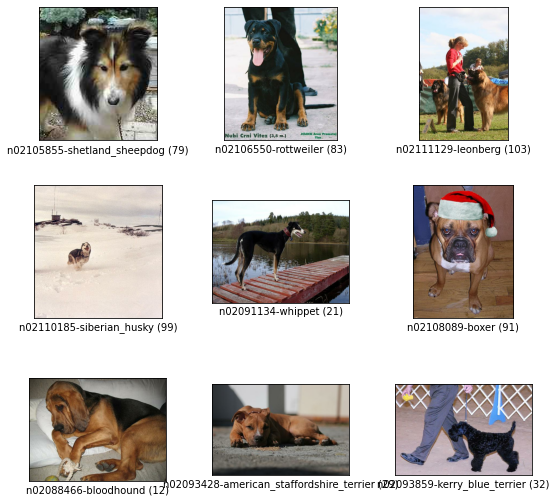

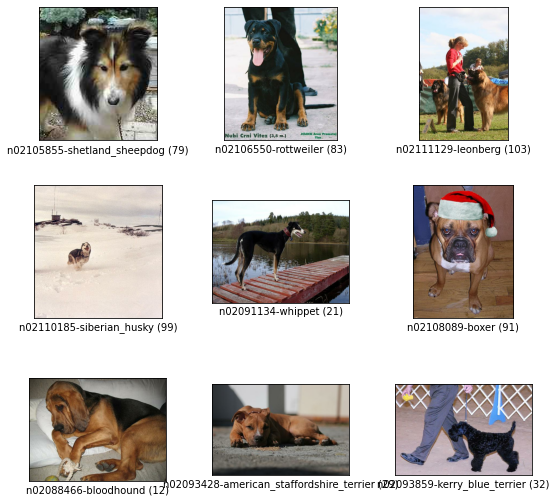

In [2]:
data_dir = '/aiffel/aiffel/aiffel_quest'

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir=data_dir
)
num_classes = ds_info.features['label'].num_classes
tfds.show_examples(ds_train, ds_info)

## 2. 전처리

### 2.1 전처리 함수
- **normalize_and_resize_img()** : 학습 데이터와 검증 데이터 normalizing, resizing
    - input : bbox 제외 : **weakly supervised learning**을 통해 물체 영역을 간접적으로 학습 가능
       → object detection, segmentation에 직접적인 라벨 없이(bbox) 활용 가능
        
- **apply_normalize_on_dataset()** : 배치 구성

In [3]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2.2 전처리 적용
- 모델 학습에 사용할 데이터 전처리
    - `ds_train_norm`, `ds_val_norm`
- 구성된 배치의 모양 확인
    - 배치 사이즈: 16

In [4]:
# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


## 3. ResNet50 모델
### 3.1 모델 정의
- ImageNet으로 훈련된 ResNet50모델
    - pooling : avg
    - 새로운 fully connected layer : softmax layer
- 특성 맵 (feature map) : conv5_block3_out의 output
    - (feature map) → Gap 적용 → (크기가 줄어든 feature map) → Dense layer → (확률 출력)
    - → Dense layer의 가중치와 feature map의 채널별 값 → 활성화 맵 → CAM

In [5]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output

# 분류 층 추가
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

# 새로운 모델 정의
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

### 3.2 모델 학습
- `ds_train_norm`, `ds_val_norm`을 사용하여 epoch 20 수행

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

### 3.3 모델 저장
- 모델 저장
    - `cam_model.save()`
- 가중치 저장
    - import pickle
    - `pickle.dump()`

In [ ]:
drive_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest3/models/'

# no_aug_resnet50 모델 저장 (아무것도 적용하지 않은 데이터셋 사용)
cam_model.save(drive_path + 'cam_model1.h5')

with open(drive_path + 'history_cam_model.pkl', 'wb') as f:
    pickle.dump(history_cam_model.history, f)